In [27]:
import matplotlib.pyplot as plt 
import json
from glob import glob

from collections import defaultdict
import os
import numpy as np

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

dataset_names=[
    "adult",
    "electricity",
    "forest_cover",
    "hyperplane_high_gradual_drift",
    "insects",
    "movingRBF",
    "moving_squares",
    "new_airlines",
    "rialto",
    "river_aggrawal",
    "river_anomalysine",
    "river_hyperlane_2",
    "river_hyperlane",
    "river_led",
    "river_led_default_drift",
    "river_mixed",
    "river_randomRBF_2",
    "river_randomRBF",
    "river_randomRBF_drift",
    "river_randomTree_2",
    "river_randomTree",
    "river_SEA_2",
    "river_SEA",
    "river_SINE",
    "river_STAGGER",
    "river_Waveform_2",
    "river_Waveform",
    "sea_high_abrupt_drift",
    "sea_high_mixed_drift",
    "shuttle",
    "skmul_aggrawal",
    "skmul_anomalysine_2",
    "skmul_anomalysine",
    "skmul_hyperlane",
    "skmul_ledgenerator",
    "skmul_ledgenerator_default_drift",
    "skmul_randomRBF_default_drift",
    "skmul_randomRBF_gradual",
    "skmul_randomTree_2",
    "skmul_randomTree",
    "skmul_SEA_2",
    "skmul_SEA",
    "skmul_Sine",
    "skmul_STAGGER_2",
    "skmul_STAGGER",
    "skmul_Waveform",
    "synth_agrawal",
    "synth_RandomRBFDrift",
    "vehicle_sensIT",
    "weather"
]


model_names=('HATC','ARFC','AutoClass','AutoStreamML','SRPC', 'EvoAutoML',"OnlineAutoML")
# model_names=('ARFC','AutoStreamML','SRPC', 'HATC')

dataset_by_model={}
for dataset in dataset_names:
    dataset_by_model[dataset]={}

for model in model_names:
    for dataset in dataset_names:
        dataset_by_model[dataset][model]=glob(f'./experiment-results/{model}/{model}_{dataset}*')

In [28]:
def kappa_no_chan_probs(window_size, class_values):
    class_values = np.array(class_values)  # Ensure it's a NumPy array
    num_class = len(np.unique(class_values))

    no_change_probabilities = []

    for start in range(0, len(class_values) - window_size + 1, window_size):
        end = start + window_size
        window_class_values = class_values[start:end]

        transitions = 0.0
    
        for j in range(num_class):
            transition = np.sum((window_class_values[:-1] == j) & (window_class_values[1:] == j))
            transitions += transition

        probability = transitions / (len(window_class_values) - 1) if len(window_class_values) > 1 else 0
        no_change_probabilities.append(probability)
    
    return np.array(no_change_probabilities)

def kappa_chan_probs(window_size, class_values):
    num_class = len(class_values.unique())  # Number of unique classes
    total_instances = len(class_values)     # Total number of instances

    # Calculate marginal probabilities of each class
    marginal_probs = class_values.value_counts(normalize=True).values
    
    # Expected agreement (accuracy of random chance classifier)
    expected_agreement = np.sum(marginal_probs ** 2)
    
    # Compute chance accuracy per window
    no_change_probabilities = []
    # class_values = np.array(class_values)  # Convert to numpy array for slicing

    for start in range(0, len(class_values) - window_size + 1, window_size):
        window = class_values[start:start + window_size]
        marginal_probs = window.value_counts(normalize=True).values
        expected_agreement = np.sum(marginal_probs ** 2)
        
        # Compute frequency of each class in the window
        window_counts = np.bincount(window, minlength=num_class)


        window_probs = window_counts / window_size

        # Compute probability of a random classifier being correct in this window
        no_change_prob = np.sum(window_probs ** 2)
        no_change_probabilities.append(no_change_prob)

    return np.array(no_change_probabilities)
    
def downsample(data, window_size):
    """Averages every `window_size` instances."""
    n = len(data) // window_size * window_size  # Trim to multiple of window_size
    return data[:n].reshape(-1, window_size).mean(axis=1)

def convert_snake_case_to_title_case(snake_case_string):
    """
    Converts a snake_case string to Title Case.

    Args:
        snake_case_string: The input string in snake_case.

    Returns:
        The string converted to Title Case.
    """
    if snake_case_string=='movingRBF':#1
        return 'Moving RBF'
    elif snake_case_string== 'synth_agrawal':#2
        return 'Agrawal'
    elif snake_case_string== 'vehicle_sensIT':#3
        return 'Vehicle SensIT'
    elif snake_case_string== 'sea_high_abrupt_drift':#4
        return 'SEA High Abrupt Drift'
    elif snake_case_string== 'sea_high_mixed_drift':#5
        return 'SEA High Mixed Drift'
    # elif snake_case_string== 'sea_high_mixed_drift':#6
        # return 'synth_RandomRBFDrift'
    elif snake_case_string== 'synth_RandomRBFDrift':#7
        return 'Random RBF Drift'
    else:
        words = snake_case_string.split('_')
        title_case_words = [word.capitalize() for word in words]
        return ' '.join(title_case_words)

In [29]:
default_config=True

mean_scores_for_stat_test={}
for dataset in dataset_names:
    mean_scores_for_stat_test[dataset]={}

mean_energy_for_stat_test={}
for dataset in dataset_names:
    mean_energy_for_stat_test[dataset]={}

mean_time_for_stat_test={}
for dataset in dataset_names:
    mean_time_for_stat_test[dataset]={}

mean_kappa_for_stat_test={}
for dataset in dataset_names:
    mean_kappa_for_stat_test[dataset]={}

mean_kappa_plus_for_stat_test={}
for dataset in dataset_names:
    mean_kappa_plus_for_stat_test[dataset]={}

across_dataset_mean_scores_for_stat_test = {}
across_dataset_mean_energy_for_stat_test = {}
across_dataset_mean_time_for_stat_test = {}
across_dataset_mean_kappa_for_stat_test = {}
across_dataset_mean_kappa_plus_for_stat_test = {}



In [30]:


model_names=('HATC','ARFC','AutoClass','AutoStreamML','SRPC', 'EvoAutoML',"OnlineAutoML")

for data_idx, data_name in enumerate(dataset_names):

    real_dataset = pd.read_csv(f'stream_datasets/{data_name}.csv')
    class_values = real_dataset['class']
    if len(class_values)>100000:
        window_size=10000
    else:
        window_size=1000

    
    threshold = int(len(class_values) - window_size)

    
    class_values=class_values[:threshold]

    no_change_probabilities=kappa_no_chan_probs(window_size=window_size,class_values=class_values)



    chance_probabilities=kappa_chan_probs(window_size=window_size,class_values=class_values)


    
    for model in model_names:

        all_scores, all_time, all_energy, all_kappa, all_kappa_plus = [], [], [], [], []

        for sample in dataset_by_model[data_name][model]:
            if default_config==True:
                if model=='AutoClass':
                    if 'population_size_10_exploration_window_1000' not in sample:
                        continue
                if model == 'AutoStreamML':
                    if 'exploration_window_1000_ensemble_size_3_budget_10' not in sample:
                        continue
                if model == 'EvoAutoML':
                    if 'population_size_10_sampling_size_1_sampling_rate_1000' not in sample:
                        continue
                if model == 'OnlineAutoML':
                    if 'default' not in sample:
                        continue
                if model == 'SRPC' or model =='ARFC' or model=='HATC':
                    if 'nmodel_3' not in sample:
                        continue
            with open(sample) as f:
                data = json.load(f)

            prequential_scores = np.array(data['prequential_scores'])
            time = np.array(data['time'])
            energy_consumed = np.array(data['energy_consumed'])
            # carbon_emissioned = np.array(data['emission'])



            if len(prequential_scores) < threshold or len(time) < threshold or len(energy_consumed) < threshold:

                continue



            prequential_scores = prequential_scores[:threshold]
            time = time[:threshold]
            energy_consumed = energy_consumed[:threshold]
            # carbon_emissioned=carbon_emissioned[:threshold]


            prequential_scores=downsample(prequential_scores,window_size)
            time=downsample(time,window_size)
            energy_consumed=downsample(energy_consumed,window_size)

            kappa_no_change_mean = (prequential_scores - no_change_probabilities) / (1 - no_change_probabilities)
            kappa_chance_mean = (prequential_scores - chance_probabilities) / (1 - chance_probabilities)


    
        # Append to the lists
            all_scores.append(prequential_scores)
            all_time.append(time)
            all_energy.append(energy_consumed)
            all_kappa.append(kappa_chance_mean)
            all_kappa_plus.append(kappa_no_change_mean)
            # all_emission.append(carbon_emissioned)

            # all_scores.append(prequential_scores)
            # all_time.append(time)
            # all_energy.append(energy_consumed)

        all_scores, all_time, all_energy, all_kappa, all_kappa_plus = np.array(all_scores), np.array(all_time), np.array(all_energy), np.array(all_kappa), np.array(all_kappa_plus)

        mean_scores, std_scores = np.mean(all_scores, axis=0), np.std(all_scores, axis=0)
        mean_time, std_time = np.mean(all_time, axis=0), np.std(all_time, axis=0)
        mean_energy, std_energy = np.mean(all_energy, axis=0), np.std(all_energy, axis=0)
        mean_kappa, std_kappa = np.mean(all_kappa, axis=0), np.std(all_kappa, axis=0)
        mean_kappa_plus, std_kappa_plus = np.mean(all_kappa_plus, axis=0), np.std(all_kappa_plus, axis=0)

        # mean_emission, std_emission= np.mean(all_emission, axis=0), np.std(all_emission, axis=0)

        mean_scores_for_stat_test[data_name][model]=mean_scores
        mean_energy_for_stat_test[data_name][model]=mean_energy
        mean_time_for_stat_test[data_name][model]=mean_time
        mean_kappa_for_stat_test[data_name][model]=mean_kappa
        mean_kappa_plus_for_stat_test[data_name][model]=mean_kappa_plus

        # print(len(mean_scores))


In [31]:
for mode in model_names:

    stat_scores = []
    stat_energy = []
    stat_time = []
    stat_kappa = []
    stat_kappa_plus = []

    for datase in dataset_names:

        stat_scores.append(np.mean(mean_scores_for_stat_test[datase][mode], axis=0))
        stat_energy.append(np.mean(mean_energy_for_stat_test[datase][mode], axis=0))
        stat_time.append(np.mean(mean_time_for_stat_test[datase][mode], axis=0))
        stat_kappa.append(np.mean(mean_kappa_for_stat_test[datase][mode], axis=0))
        stat_kappa_plus.append(np.mean(mean_kappa_plus_for_stat_test[datase][mode], axis=0))

    across_dataset_mean_scores_for_stat_test[mode] = stat_scores
    across_dataset_mean_energy_for_stat_test[mode] = stat_energy
    across_dataset_mean_time_for_stat_test[mode] = stat_time
    across_dataset_mean_kappa_for_stat_test[mode] = stat_kappa
    across_dataset_mean_kappa_plus_for_stat_test[mode] = stat_kappa_plus


# Critical Diagrams with Friedman Test

In [32]:
import numpy as np
import pandas as pd
import numpy as np


acc=across_dataset_mean_scores_for_stat_test
# Convert to DataFrame
df_acc = pd.DataFrame(acc)
print(df_acc.head())


       HATC      ARFC  AutoClass  AutoStreamML      SRPC  EvoAutoML  \
0  0.811308  0.805877   0.779883      0.805425  0.796058   0.820920   
1  0.849345  0.864078   0.891745      0.926353  0.883992   0.904748   
2  0.739048  0.879645   0.941914      0.934927  0.909496   0.925836   
3  0.842503  0.747396   0.760921      0.909801  0.725214   0.869079   
4  0.584761  0.665636   0.643026      0.681974  0.665914   0.666670   

   OnlineAutoML  
0      0.799085  
1      0.855034  
2      0.861313  
3      0.865562  
4      0.544309  


In [33]:
plt.rcParams.update({'font.size': 18})

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Test used:  friedman
Posthoc used:  nemenyi


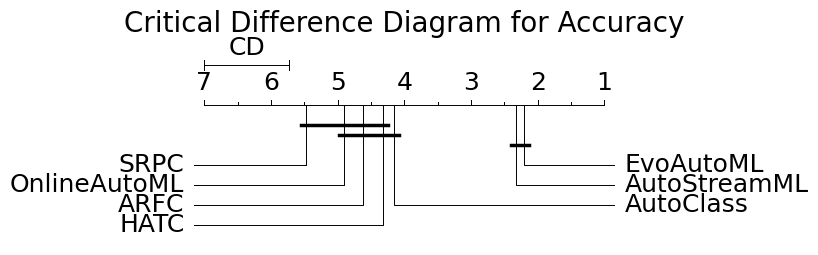

In [34]:
import matplotlib.pyplot as plt
from autorank import plot_stats, autorank
# Lower energy = better (set 'ascending=False' if higher is better)
result = autorank(df_acc, alpha=0.05, order='descending', verbose=False,force_mode='nonparametric')

print("Test used: ",result.omnibus)
print("Posthoc used: ",result.posthoc)
# Generate the CD diagram
plot_stats(result)
plt.title("Critical Difference Diagram for Accuracy",fontsize=20)
plt.tight_layout()
plt.show()

In [35]:
time=across_dataset_mean_time_for_stat_test
# Convert to DataFrame
df_time = pd.DataFrame(time)
print(df_time.head())


       HATC      ARFC  AutoClass  AutoStreamML      SRPC  EvoAutoML  \
0  0.000409  0.000759   0.013114      0.004382  0.002072   0.009681   
1  0.000358  0.000676   0.011079      0.001812  0.001776   0.005517   
2  0.001746  0.001140   0.036087      0.009515  0.006560   0.008367   
3  0.000463  0.001003   0.012811      0.001877  0.002169   0.004401   
4  0.001248  0.001126   0.032265      0.011412  0.006620   0.021843   

   OnlineAutoML  
0      0.015267  
1      0.043586  
2      0.084422  
3      0.024473  
4      0.030043  


Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Test used:  friedman
Posthoc used:  nemenyi


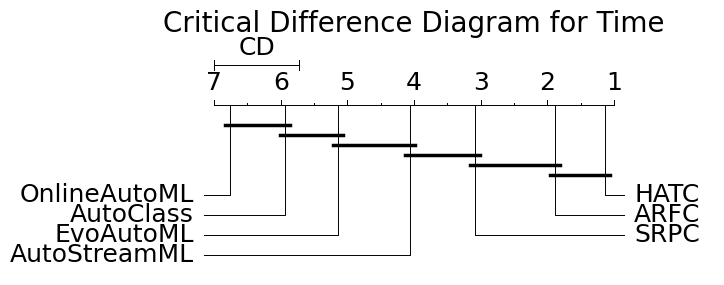

In [36]:
import matplotlib.pyplot as plt
from autorank import plot_stats, autorank
# Lower energy = better (set 'ascending=False' if higher is better)
result = autorank(df_time, alpha=0.05, order='ascending', verbose=False,force_mode='nonparametric')

print("Test used: ",result.omnibus)
print("Posthoc used: ",result.posthoc)
# Generate the CD diagram
plot_stats(result)
plt.title("Critical Difference Diagram for Time",fontsize=20)
plt.tight_layout()
plt.show()

In [37]:
energy=across_dataset_mean_energy_for_stat_test
# Convert to DataFrame
df_energy = pd.DataFrame(energy)
print(df_energy.head())


           HATC          ARFC     AutoClass  AutoStreamML          SRPC  \
0  5.416576e-08  7.347019e-08  4.606244e-07  1.635956e-07  1.075263e-07   
1  5.271362e-08  6.003606e-08  3.790159e-07  9.270061e-08  9.189087e-08   
2  9.320628e-08  8.953729e-08  1.127040e-06  3.592723e-07  2.545098e-07   
3  6.091928e-08  7.627350e-08  4.620279e-07  1.047635e-07  1.151380e-07   
4  8.621618e-08  8.099539e-08  1.032013e-06  4.296777e-07  2.508176e-07   

      EvoAutoML  OnlineAutoML  
0  3.491859e-07  4.589973e-07  
1  2.137217e-07  1.210230e-06  
2  3.120553e-07  3.118753e-06  
3  1.882020e-07  8.578181e-07  
4  7.777609e-07  1.013943e-06  


Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Test used:  friedman
Posthoc used:  nemenyi


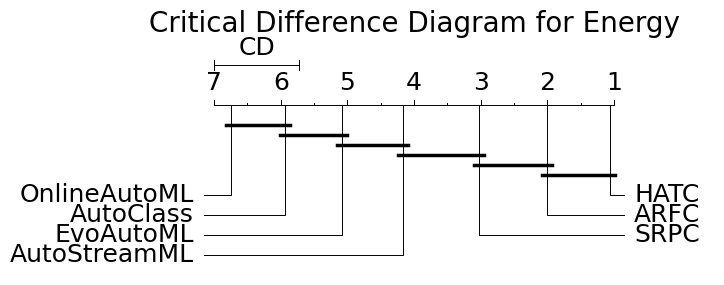

In [38]:
# Lower energy = better (set 'ascending=False' if higher is better)
result = autorank(df_energy, alpha=0.05, order='ascending', verbose=False,force_mode='nonparametric')

print("Test used: ",result.omnibus)
print("Posthoc used: ",result.posthoc)
# Generate the CD diagram
plot_stats(result)
plt.title("Critical Difference Diagram for Energy",fontsize=20)
plt.tight_layout()
plt.show()

In [39]:
kappa=across_dataset_mean_kappa_for_stat_test
# Convert to DataFrame
df_kappa = pd.DataFrame(kappa)
print(df_kappa.head())

       HATC      ARFC  AutoClass  AutoStreamML      SRPC  EvoAutoML  \
0  0.486154  0.471466   0.400133      0.470207  0.444800   0.511872   
1  0.685213  0.716078   0.773927      0.846091  0.757578   0.801037   
2  0.489121  0.757803   0.882554      0.868469  0.816633   0.849475   
3  0.684974  0.494742   0.521794      0.819584  0.450372   0.738132   
4      -inf      -inf       -inf          -inf      -inf       -inf   

   OnlineAutoML  
0      0.453122  
1      0.697230  
2      0.724480  
3      0.731098  
4          -inf  


Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Test used:  friedman
Posthoc used:  nemenyi


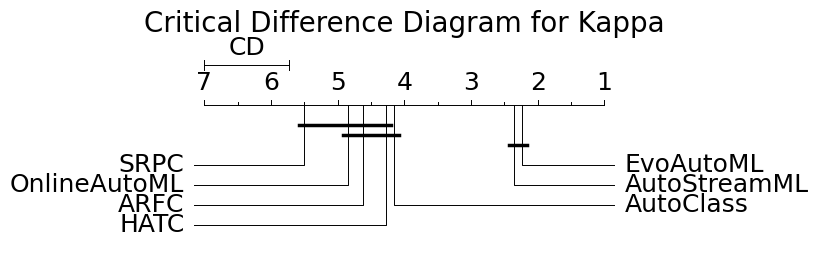

In [40]:
result = autorank(df_kappa, alpha=0.05, order='descending', verbose=False,force_mode='nonparametric')

print("Test used: ",result.omnibus)
print("Posthoc used: ",result.posthoc)
# Generate the CD diagram
plot_stats(result)
plt.title("Critical Difference Diagram for Kappa",fontsize=20)
plt.tight_layout()
plt.show()

In [41]:
kappa_plus=across_dataset_mean_kappa_plus_for_stat_test
# Convert to DataFrame
df_kappa_plus = pd.DataFrame(kappa_plus)
print(df_kappa_plus.head())

       HATC      ARFC  AutoClass  AutoStreamML      SRPC  EvoAutoML  \
0  0.483686  0.468871   0.397537      0.467622  0.441937   0.509833   
1 -0.062112  0.044952   0.236170      0.481095  0.181849   0.327859   
2 -6.007801 -2.227165  -0.552285     -0.699533 -1.412494  -0.979162   
3  0.685356  0.495353   0.522367      0.819797  0.451046   0.738445   
4      -inf      -inf       -inf          -inf      -inf       -inf   

   OnlineAutoML  
0      0.450274  
1     -0.005954  
2     -2.569298  
3      0.731403  
4          -inf  


Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Test used:  friedman
Posthoc used:  nemenyi


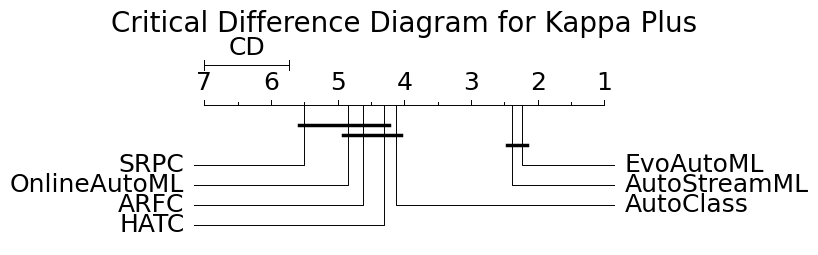

In [42]:
result = autorank(df_kappa_plus, alpha=0.05, order='descending', verbose=False,force_mode='nonparametric')

print("Test used: ",result.omnibus)
print("Posthoc used: ",result.posthoc)
# Generate the CD diagram
plot_stats(result)
plt.title("Critical Difference Diagram for Kappa Plus",fontsize=20)
plt.tight_layout()
plt.show()

In [43]:
from scipy.stats import friedmanchisquare

stat,p=friedmanchisquare(across_dataset_mean_scores_for_stat_test['AutoClass'],
                         across_dataset_mean_scores_for_stat_test['AutoStreamML'],
                         across_dataset_mean_scores_for_stat_test['EvoAutoML'],
                         across_dataset_mean_scores_for_stat_test['OnlineAutoML'],
                         across_dataset_mean_scores_for_stat_test['ARFC'],
                         across_dataset_mean_scores_for_stat_test['HATC'],
                         across_dataset_mean_scores_for_stat_test['SRPC'])

p

np.float64(7.221298789168775e-20)